In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [38]:
event_data = pd.read_csv('event_data_train.csv')

In [39]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [40]:
event_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [41]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [42]:
event_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [46]:
event_data['date'] = pd.to_datetime(event_data.timestamp, unit='s')

In [47]:
event_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [48]:
event_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [49]:
event_data['day'] = event_data.date.dt.date

In [51]:
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [55]:
sns.set(rc={'figure.figsize': (12, 8)})

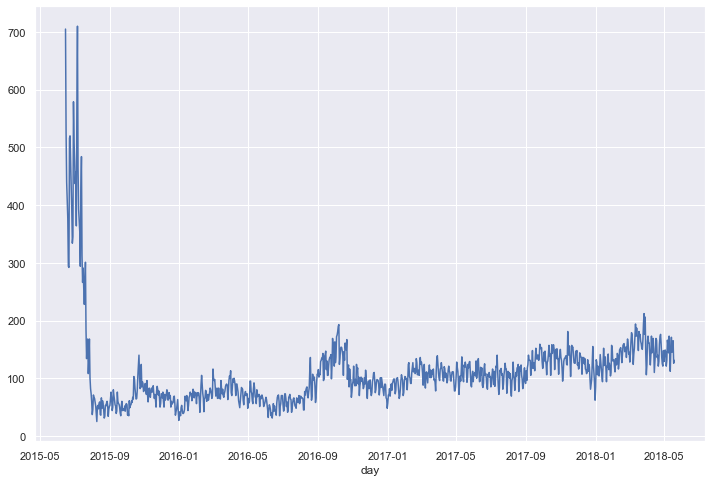

In [58]:
event_data.groupby('day').user_id.nunique().plot();

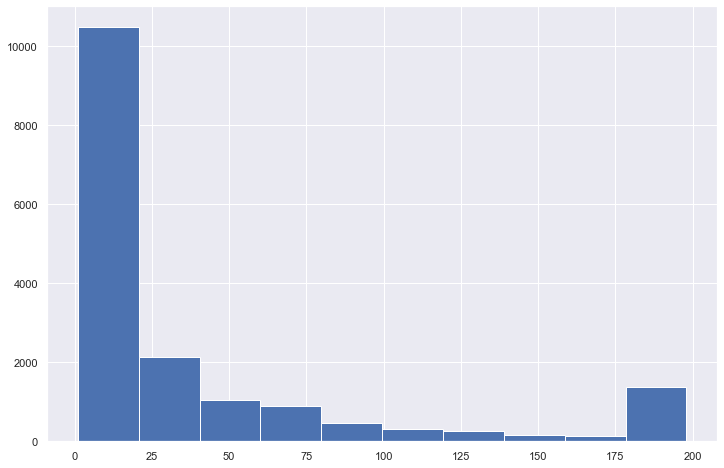

In [63]:
event_data.query('action == "passed"').groupby('user_id', as_index=False) \
        .agg({'step_id': 'count'}).rename(columns={'step_id': 'passed_steps'}).passed_steps.hist();

In [165]:
users_event_data = event_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [167]:
users_event_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


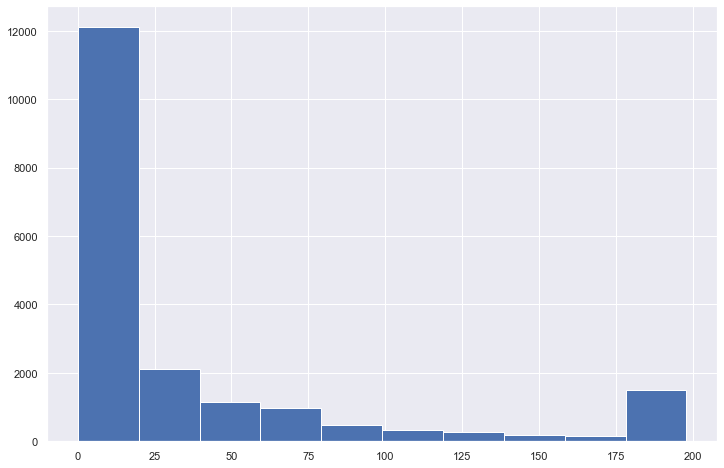

In [166]:
users_event_data.discovered.hist();

In [72]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [73]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [76]:
users_scores = submissions_data.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0) \
        .reset_index()

In [124]:
gap_data = event_data[['user_id', 'timestamp', 'day']].drop_duplicates(subset=['user_id', 'timestamp']) \
    .groupby('user_id').timestamp.apply(list).apply(np.diff)

In [131]:
gap_data = gap_data[gap_data.apply(lambda lst: len(lst) > 0)].apply(max)

In [132]:
gap_data.head()

user_id
2     4843411
3     6898143
5    33702812
8      862756
9          25
Name: timestamp, dtype: int64

In [133]:
gap_data = gap_data / (24 * 60 * 60)

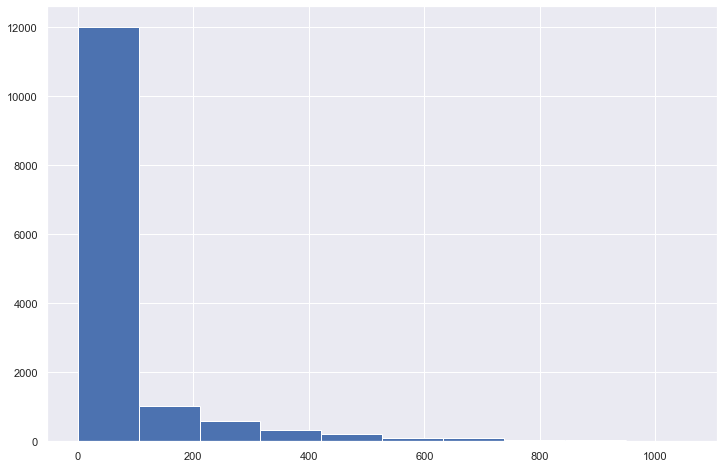

In [145]:
gap_data.hist();

In [147]:
gap_data.quantile(0.95)

345.30406597222213

In [143]:
gap_data.median()

4.184415509259259

In [150]:
event_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [153]:
users_data = event_data.groupby('user_id', as_index=False).agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [156]:
now_timestamp = 1526772811
dropout_threshold = 30 * 24 * 60 * 60

In [157]:
users_data['is_gone_user'] = (now_timestamp - users_data['last_timestamp']) > dropout_threshold

In [159]:
users_data.is_gone_user.value_counts()

True     17844
False     1390
Name: is_gone_user, dtype: int64

In [163]:
users_data = users_data.merge(users_scores, on='user_id', how='outer').fillna(0)

In [164]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [169]:
users_data = users_data.merge(users_event_data, on='user_id', how='outer')

In [177]:
users_days = event_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [178]:
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [179]:
users_data = users_data.merge(users_days, on='user_id', how='outer')

In [180]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
